In [1]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy.stats import entropy
import seaborn as sns

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from models.networks_2022 import BranchedNetwork
from data.CleanSoundsDataset import CleanSoundsDataset
from data.NoisyDataset import NoisyDataset

# Parameters

In [2]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
checkpoints_dir = f'{engram_dir}checkpoints/'
tensorboard_dir = f'{engram_dir}tensorboard/'
activations_dir = f'{engram_dir}activations_pnet/'

In [3]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cuda:0


# Function to collect accuracy values

In [4]:
def top_n_entropy(logits, n=50):
    logits = logits.squeeze()
    if n is not None:
        idxs = np.argpartition(logits, -n)[-n:]
        logits = logits[idxs]
    result = entropy(np.exp(logits), base=2)
    return result

In [5]:
def eval_accuracy(
    results, dset, ff_correct=None, clean_correct=None
    ):
    
    idxs = np.ones(dset.n_data).astype(bool)
    if ff_correct is not None:
        if ff_correct:
            idxs = np.logical_and(idxs, np.logical_not(dset.net_mistakes))
        else:
            idxs = np.logical_and(idxs, dset.net_mistakes)
    if clean_correct is not None:
        clean_correct_idxs = dset.labels == np.array(results['0_clean_output'])
        if clean_correct:
            idxs = np.logical_and(idxs, clean_correct_idxs)
        else:
            idxs = np.logical_and(idxs, np.logical_not(clean_correct_idxs))
    idxs = np.argwhere(idxs).squeeze()
    net_type = []
    accuracies = []
    
    n_timesteps = 5
    for i in idxs:
        clean_input = dset.clean_in[i].reshape((164, 400))
        label = results['label'][i]
        entro = top_n_entropy(results[f'{0}_logits'][i])
        
        # FF
        ff_acc = label == results[f'{0}_output'][i]
        net_type.append('FF')
        accuracies.append(ff_acc)
        
        # Predictive
        pnet_acc = label == results[f'{4}_output'][i]
        net_type.append('PNet')
        accuracies.append(pnet_acc)
        
        # Adaptive
        if entro > 2.:
            ada_acc = pnet_acc
        else:
            ada_acc = ff_acc
        net_type.append('Ada')
        accuracies.append(ada_acc)
            
    return net_type, accuracies

In [6]:
# This is bad practice! But the warnings are real annoying
import warnings
warnings.filterwarnings("ignore")

In [7]:
bgs = ['AudScene', 'Babble8Spkr']
snrs = [-9.0, -6.0, -3.0, 0.0, 3.0]

# All

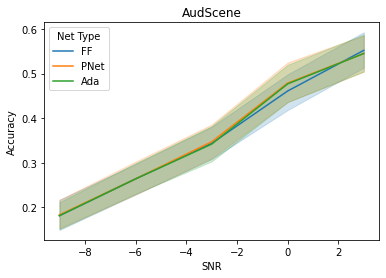

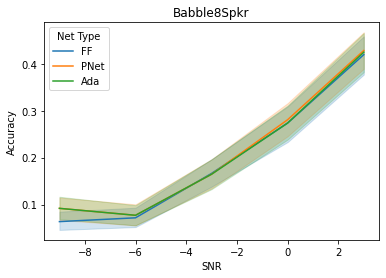

In [8]:
for bg in bgs:
    data = {}
    data['Net Type'] = []
    data['Accuracy'] = []
    data['SNR'] = []
    for snr in snrs:
        dset = NoisyDataset(bg, snr)
        results_path = f'{activations_dir}{bg}_snr{int(snr)}.hdf5'
        results = h5py.File(results_path, 'r')
        net_type, accs = eval_accuracy(results, dset)
        data['Net Type'].extend(net_type)
        data['Accuracy'].extend(accs)
        data['SNR'].extend([snr]*len(accs))
    df = pd.DataFrame(data)
    g = sns.lineplot(x='SNR', y='Accuracy', hue='Net Type', data=df)
    plt.title(f'{bg}')
    plt.show(g)